# How to Train a Neural Network

The purpose of this presentation is to demonstrate the power of neural networks through training and hyperparameter tuning. The presentation follows the following format:
1. Identification of a Business Problem
2. Description of the Dataset
3. Why use Neural Networks (contrast with simple model)
4. Results and Business Impact
5. Next Steps/ Recommendations

**Business Problem**
Modern organizations (news outlets, financial firms, research institutions) handle huge volumes of unstructured text data — articles, reports, emails, documents.
Manually categorizing and tagging them by topic (e.g., Economics, Trade, Government, Markets) is time-consuming and inconsistent.

**Description of the Dataset**
For this example we're using the RCV1 dataset. This dataset is high dimensional (with about 47,000 word features)  and multi-label (where each news article can belong to multiple topics).

**Why use a Neural Network?**
A neural network can model non-linear patterns and complex word interactions better than simple linear classifiers. Compared to logistic regression, it can capture contextual relationships — for instance, “interest rates” and “central bank” appearing together are strong signals for Monetary Policy.

**Possible Business Applications**
A neural network can:
 1. Auto-tag incoming new articles by topic or indistry.
    2. Route content to specialized teams (e.g. Finance, Policy, Legal)
    3. Feed dashboards that track trends across topics over time.
    4. Speed up content indexing in news or financial analytics platforms

**How Businesses Can Use It?**
1. Media comapnies can use it to automatically organize content and improve search accuracy
2. Investment firms can use it to detect emerging trends or sector-specific developments in real-time news feeds
3. COnsulting / Research firms can use it to summarize and categorize large document corpora efficiently

## Step 1: Import the Relevant Libraries

In [14]:
#import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Step 2: Import the Dataset ##

The RCV1 dataset (Reuters Corpus Volume I) is a large benchmark text dataset used for text classification, topic modeling, and NLP experiments. It contains over 800,000 manually categorized newswire stories from Reuters, covering topics like corporate/industrial news, economics, politics, and more. There are four major labels:
1. CCAT - Corporate/ Industrial
2. ECAT - Economics
3. GCAT - Government/ Social
4. MCAT - Markets

**Size:** approximately 800,000 documents
**Format**
When you load RCV1 using scikit-learn, you'll get a preprocessed machine learning ready version of the dataset. Here's what's inside:
| Attribute            | Description                                                                                                                            |
| -------------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| `rcv1.data`          | A **(804,414 × 47,236)** sparse TF-IDF matrix of features — each column represents a token (word or term).                             |
| `rcv1.target`        | A **multilabel matrix** (804,414 × 103) — each column is a topic category, and each row indicates which topics apply to that document. |
| `rcv1.sample_id`     | A list of 804,414 unique story IDs (e.g., `'2286'`, `'2994'`).                                                                         |
| `rcv1.target_names`  | The names of the 103 topic labels (e.g., `'C11'`, `'E51'`, `'G15'`, `'M14'`, etc.).                                                    |

**NOTE 1:** The rcv1.data is a sparse TF-IDF matrix meaning that it is already preprocessed and tokenized. It's in a numerical form and not human-readable words.

**NOTE 2:** TF-IDF stands for Term Frequency -Inverse Document Frequency. It's a numerical representation of how important each word (token) is to a document, compared to all other documents.
The dataset stores this as a matrix with:
1. Rows = documents
2. Columns = tokens (words or terms)
3. Cell value = TF-IDF score of that word in that document

**Note 3:** It's sparse because most documents don’t contain most words, so most values are 0.

Here's a simplified example of what a TF-IDF matrix can look like:
| Word  | oil  | germany | sony | inflation |
| ----- | ---- | ------- | ---- | --------- |
| Doc 1 | 0.34 | 0.00    | 0.00 | 0.00      |
| Doc 2 | 0.00 | 0.42    | 0.00 | 0.38      |
| Doc 3 | 0.00 | 0.00    | 0.46 | 0.00      |

**NOTE 4:** So the actual rcv1.data looks like a large (804,414 × 47,236) sparse matrix — about 47k unique tokens across 800k docs.


In [3]:
#load the data
from sklearn.datasets import fetch_rcv1
rcv1 = fetch_rcv1()

In [4]:
print(rcv1.DESCR)  # description of the dataset


.. _rcv1_dataset:

RCV1 dataset
------------

Reuters Corpus Volume I (RCV1) is an archive of over 800,000 manually
categorized newswire stories made available by Reuters, Ltd. for research
purposes. The dataset is extensively described in [1]_.

**Data Set Characteristics:**

==============     =====================
Classes                              103
Samples total                     804414
Dimensionality                     47236
Features           real, between 0 and 1
==============     =====================

:func:`sklearn.datasets.fetch_rcv1` will load the following
version: RCV1-v2, vectors, full sets, topics multilabels::

    >>> from sklearn.datasets import fetch_rcv1
    >>> rcv1 = fetch_rcv1()

It returns a dictionary-like object, with the following attributes:

``data``:
The feature matrix is a scipy CSR sparse matrix, with 804414 samples and
47236 features. Non-zero values contains cosine-normalized, log TF-IDF vectors.
A nearly chronological split is proposed in [1

In [4]:
print(rcv1.data.shape)    # the number of samples and features
print(rcv1.target.shape)  # the number of samples and labels


(804414, 47236)
(804414, 103)


In [6]:
print(rcv1.keys())

dict_keys(['data', 'target', 'sample_id', 'target_names', 'DESCR'])


## Step 3: Data Preprocessing

For the purposes of this demo and due to limited processing power, we would like to take a sample of the documents. It is also recommended to convert the sparse matric to a dense array.

**Dense tensor:** every element is stored explicitly (like a normal NumPy array).
**Sparse tensor:** only non-zero elements are stored, because most values are zero.

**NOTE:** This is important for our dataset as most words don’t appear in any given document so there are lots of zeros. Neural networks expect dense tensors because they do lots of matrix multiplications and need explicit values for every position.

In [5]:
#Convert the sparse matrix data to dense format
X = rcv1.data[:10000].toarray()
y = rcv1.target[:10000].toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split the data into training and testing sets

In [6]:
print(X_train.shape)
print(y_train.shape)

(8000, 47236)
(8000, 103)


## Step 4: Build the Neural Network

Here we are creating the architecture of the Neural Network. FOr this baseline model, the # of hidden layers, and neurons per hidden layer are assumptions. We'll then test the model's accuracy and adjust these hyperparameters accordingly. Note, there are other ways of identifying these baseline hyperparameters:
1. We can use Keras Tuner, a library that helps you pick the optimal set of hyperparameters (https://www.tensorflow.org/tutorials/keras/keras_tuner)
2.  

As a reminder, here's a depiction of a basic feedforward neural network with 3 hidden layers. 

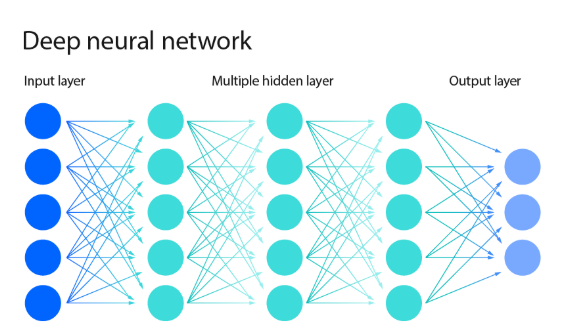

Image SOurce: https://www.ibm.com/think/topics/backpropagation#741977107

Here's another example of a Neural Network with features, hidden layers, and predictions (I like this one better)
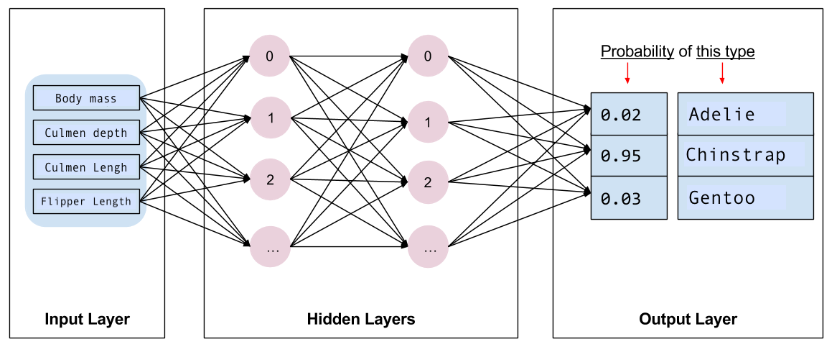

Image Source: https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough


**Data Flow through the Neural Network** 
1. Input Layer - this layer receives the numerical representation of the news articles ( each article is a vector of numbers)
2. Hidden Layer 1, Feature detection - each neuron int his layer receives weighted inputs and computes 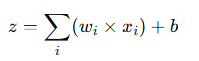 then applies the reLu activation function 
3. HIdden Layer 2: Deeper extraction - Takes outputs from the first hidden layer and applies another round of weighted sums + ReLU.
4. Output layer: Multi-label prediction: The final layer has 103 output neurons, each representing one topic label in RCV1. Each neuron receives signals from all the hidden neurons and applies a sigmoid activation: 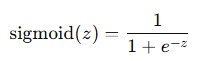 . The sigmoid converts each neuron’s value into an independent probability between 0 and 1 — “How likely is this topic relevant to the article?”. Sofmax would not work here as it only picks one class/ topic.
5. Feedback (training) -
    a. The model compares predicted probabilities vs the true binary labels using binary cross-entropy loss for each label
    b. Gradients are computed (via backpropagation) to adjust the weights and biases in every layer
    c. Over many epochs, the model learns which word patterns correspond to which topics
6. Prediction stage - Once tained, you can feed in a new article, it passes through all layers and the final 103 probabilities tells you which  topics are most relevant. You can then use this information to auto-tag or classify articles in real time.

In [7]:
#Build a baseline neural network model using Keras(Tensorflow)
model = models.Sequential([         
    layers.InputLayer(shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(y_train.shape[1], activation='sigmoid')  # Sigmoid for multi-label classification
])



## STep 5: Compile the model

This step helps us configure how our model learns.  The model.compile line tells TensorFlow how to train the neural network by specifying three major components:
1. The optimizer - how weights are updated
2. The loss function - what the model tries to minimize
3. The metrics - what performance we'd like to track.

**Optimizer = 'Adam'**
Adam (Adaptive Moment Estimation) is one of the most popular optimizers that automatically adjust the learning rate for each parameter. It decides how much to change each weight after seeing the errors.

**loss = 'binary_crossentropy**
This is the loss function (the quantity the model tries to minimize). Because we’re doing multi-label classification (each of the 103 outputs can independently be 0 or 1), you need to treat each label as a separate binary classification. Binary Cross-Entropy (BCE) measures the difference between:

The true label (0 or 1)

The predicted probability (between 0 and 1)

**Metrics**
We're measuring Precision-Recall (PR) curve and not ROC as this is better for imbalanced datasets like the rcv1.

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary crossentropy for multi-label classification
              metrics=[tf.keras.metrics.AUC(curve='PR', multi_label=True, name='pr_auc')])
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    24,185,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 103)            │        13,287 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,264,295 (92.56 MB)

 Trainable params: 24,264,295 (92.56 MB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Train the model

This is where the model 'actually learns'. By using model.fit, we're starting the training process and telling TensorFlow to feed the model batches of training data, compare predictions to the true labels, compute loss, update the weights, do this for several epochs.

**batch_size = 32**
Here we are splitting the data into batches of 32 samples and feeding it through the network. For each batch
1. Compute predictions
2. Compare predicted vs actual labels
3. Use Adam optimizer to update all layer weights

**epochs = 10**
This is the number of full passes the model will make over the training dataset where 1 epoch means that the model has seen every training example once.

In [9]:
#Train the network
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - loss: 0.1510 - pr_auc: 0.0486 - val_loss: 0.0720 - val_pr_auc: 0.1633
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - loss: 0.0588 - pr_auc: 0.2042 - val_loss: 0.0461 - val_pr_auc: 0.3424
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - loss: 0.0374 - pr_auc: 0.3608 - val_loss: 0.0372 - val_pr_auc: 0.4503
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - loss: 0.0263 - pr_auc: 0.4979 - val_loss: 0.0350 - val_pr_auc: 0.4979
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - loss: 0.0199 - pr_auc: 0.5880 - val_loss: 0.0347 - val_pr_auc: 0.5241
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - loss: 0.0158 - pr_auc: 0.6581 - val_loss: 0.0348 - val_pr_auc: 0.5568
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - loss: 0.0131 - pr_auc: 0.7064 - val_loss: 0.0363 - val_pr_auc: 0.5643
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - loss: 0.0110 - pr_auc: 0.7509 - val_loss: 0.0384 - val

In [25]:
#Evaluate the model on the test set
test_loss, test_pr_auc = model.evaluate(X_test, y_test, verbose=2)

63/63 - 1s - 10ms/step - loss: 0.0420 - pr_auc: 0.5708


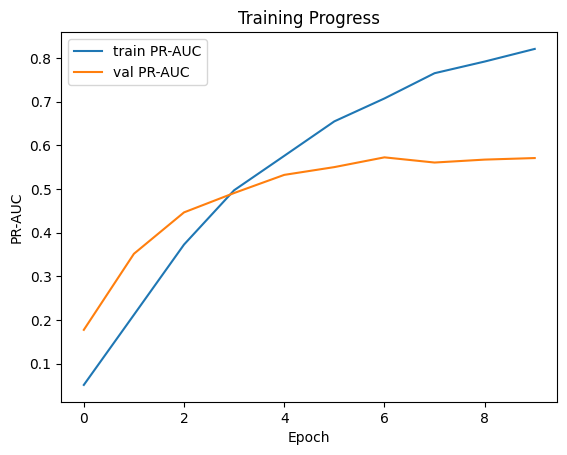

In [ ]:
#Plot model's performance on training data vs validation data   

plt.plot(history.history['pr_auc'], label='train PR-AUC')
plt.plot(history.history['val_pr_auc'], label='val PR-AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('PR-AUC')
plt.title('Training Progress')
plt.show()

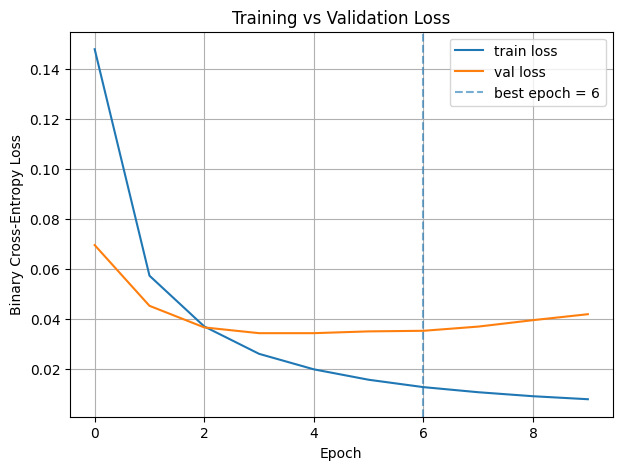

In [28]:
# --- Find best epoch by validation PR-AUC
val_pr = np.array(history.history['val_pr_auc'])
best_epoch = int(val_pr.argmax())

# --- Plot loss
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'],     label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.axvline(best_epoch, ls='--', alpha=0.6, label=f'best epoch = {best_epoch}')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
#predict probabilities on test set
y_pred = model.predict(X_test, batch_size=512)

# Convert probabilities → 0/1 predictions using threshold (say 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [11]:
print("Micro F1:", f1_score(y_test, y_pred_binary, average='micro'))
print("Macro F1:", f1_score(y_test, y_pred_binary, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_binary))


Micro F1: 0.8169873696702552
Macro F1: 0.45533895102837396
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.16      0.25        58
           1       0.82      0.64      0.72        28
           2       0.55      0.20      0.30        89
           3       0.75      0.19      0.30        16
           4       0.94      0.90      0.92       397
           5       0.94      0.87      0.90       232
           6       0.96      0.65      0.77        34
           7       0.87      0.77      0.82       178
           8       0.00      0.00      0.00         5
           9       0.81      0.65      0.72        95
          10       0.83      0.50      0.62        38
          11       0.92      0.55      0.69        20
          12       1.00      0.20      0.33         5
          13       0.94      0.80      0.86        20
          14       0.78      0.67      0.72       119
          15       0.80      0.57      0.66        9

c:\Users\kadickson\AppData\Local\anaconda3\envs\nn_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kadickson\AppData\Local\anaconda3\envs\nn_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kadickson\AppData\Local\anaconda3\envs\nn_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

In [32]:
#show some example predictions
for i in range(5):
    print(f"Sample {i+1}:")
    print("True labels: ", np.where(y_test[i]==1)[0])
    print("Predicted labels: ", np.where(y_pred_binary[i]==1)[0])
    print()

Sample 1:
True labels:  [ 44  46  59  94 102]
Predicted labels:  [ 44  46  59  94 102]

Sample 2:
True labels:  [ 4  7 33]
Predicted labels:  [ 4  5  7 33]

Sample 3:
True labels:  [44 46 59]
Predicted labels:  [44 46 59]

Sample 4:
True labels:  [ 4  7 22 33]
Predicted labels:  [ 4  7 33]

Sample 5:
True labels:  [ 4  5 33]
Predicted labels:  [ 4  5 33]



In [15]:
#map label indices to names in your results

# get names
label_names = rcv1.target_names

# create classification report as a dictionary
report_dict = classification_report(y_test, y_pred_binary, target_names=label_names, output_dict=True)

# convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# show top 10 labels by F1-score
report_df.sort_values(by="f1-score", ascending=False).head(10)

c:\Users\kadickson\AppData\Local\anaconda3\envs\nn_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kadickson\AppData\Local\anaconda3\envs\nn_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kadickson\AppData\Local\anaconda3\envs\nn_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

,precision,recall,f1-score,support
E71,1.000000,0.928571,0.962963,14.0
GSPO,0.984127,0.925373,0.953846,67.0
CCAT,0.941239,0.932275,0.936736,945.0
M11,0.950495,0.923077,0.936585,104.0
M143,0.976744,0.893617,0.933333,47.0
GCAT,0.925234,0.933962,0.929577,530.0
MCAT,0.932171,0.923225,0.927676,521.0
M14,0.950000,0.900862,0.924779,232.0
C15,0.941799,0.896725,0.918710,397.0
C151,0.939535,0.870690,0.903803,232.0


In summary

High precision → The model rarely predicts a label incorrectly.

High recall → The model rarely misses an article that truly belongs to that label.

High F1-score → The model balances both effectively.

High support → Label is well-represented, making results reliable.

The model is performing very well across the top 10 most common labels — all above 0.90 F1, which is excellent for a multi-label problem.

In [17]:
#Save the trained model
model.save('nn_baseline_model.keras')  
